### Checking the device

In [195]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# ***Libraries & Constants***

In [196]:
# set dataset path
path = 'dataset'

libraries

In [197]:
import os
import numpy as np
import random
import wave
import tensorflow as tf
import pandas as pd
from tabulate import tabulate
import librosa
import librosa.display
import soundfile as sf
from scipy.io import wavfile
import matplotlib.pyplot as plt
import IPython
from sklearn.model_selection import train_test_split
from termcolor import colored
from sklearn import metrics
from keras.models import load_model
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tqdm.keras import TqdmCallback
from tqdm import tqdm
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

The sampling rate refers to the number of samples of audio recorded every second. It is measured in samples per second or Hertz.

In [198]:
sample_rate = 4000
checkpoint_filepath = '/tmp/checkpoint'
features_samples = 30 # audio features
learning_rate = 0.001
upper_limit = 30

# ***Preprocessing***



## Downloading Dataset

In [199]:
! gdown --id 1-LbIQyVX0KSCSjAKtW2D5JGirtIkHUXs

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-LbIQyVX0KSCSjAKtW2D5JGirtIkHUXs
To: /content/FinalProjectMat.zip
100% 235M/235M [00:01<00:00, 163MB/s]


In [200]:
! unzip -qo 'FinalProjectMat.zip' -d $path

In [201]:
labels = sorted(os.listdir(path + '/piano_triads'))
labels = [label.split('.')[0] for label in labels]
# finding the unique name of notes
labels = list(map(lambda label: label[:-2], labels))
labels = np.unique(np.array(labels))
print(labels)

['A_dim_2' 'A_dim_3' 'A_dim_4' 'A_dim_5' 'A_dim_6' 'A_dim_7' 'A_maj_2'
 'A_maj_3' 'A_maj_4' 'A_maj_5' 'A_maj_6' 'A_maj_7' 'A_min_2' 'A_min_3'
 'A_min_4' 'A_min_5' 'A_min_6' 'A_min_7' 'B_dim_2' 'B_dim_3' 'B_dim_4'
 'B_dim_5' 'B_dim_6' 'B_dim_7' 'B_maj_2' 'B_maj_3' 'B_maj_4' 'B_maj_5'
 'B_maj_6' 'B_maj_7' 'B_min_2' 'B_min_3' 'B_min_4' 'B_min_5' 'B_min_6'
 'B_min_7' 'Bb_dim_2' 'Bb_dim_3' 'Bb_dim_4' 'Bb_dim_5' 'Bb_dim_6'
 'Bb_dim_7' 'Bb_maj_2' 'Bb_maj_3' 'Bb_maj_4' 'Bb_maj_5' 'Bb_maj_6'
 'Bb_maj_7' 'Bb_min_2' 'Bb_min_3' 'Bb_min_4' 'Bb_min_5' 'Bb_min_6'
 'Bb_min_7' 'C_dim_2' 'C_dim_3' 'C_dim_4' 'C_dim_5' 'C_dim_6' 'C_dim_7'
 'C_maj_2' 'C_maj_3' 'C_maj_4' 'C_maj_5' 'C_maj_6' 'C_maj_7' 'C_min_2'
 'C_min_3' 'C_min_4' 'C_min_5' 'C_min_6' 'C_min_7' 'Cs_dim_2' 'Cs_dim_3'
 'Cs_dim_4' 'Cs_dim_5' 'Cs_dim_6' 'Cs_dim_7' 'Cs_maj_2' 'Cs_maj_3'
 'Cs_maj_4' 'Cs_maj_5' 'Cs_maj_6' 'Cs_maj_7' 'Cs_min_2' 'Cs_min_3'
 'Cs_min_4' 'Cs_min_5' 'Cs_min_6' 'Cs_min_7' 'D_dim_2' 'D_dim_3' 'D_dim_4'
 'D_dim_5' 'D_dim_6'

In [202]:
numbrer_classes = len(labels)
print(numbrer_classes)

216


# ***Design Flow***

#### Some helping functions

changing the type of keras history from list into np array

In [203]:
# changing the type of keras history from list into np array
def dic_to_np_array(dic):
    np_dic = {}
    for key in dic.keys():
        np_dic[key] = np.array(dic[key])
    iterations = np.arange(start=1, stop=len(np_dic['loss']) + 1)
    np_dic["iterations"] = iterations

    return np_dic

remove all checkpoints data

Drawing Plot : drawing the plot for accuacy and loss in train and valid

In [204]:
def draw_plot(title, accuracy_loss, k=1):
    # reset plt syle
    plt.style.use('default')
    print("\n")
    plt.figure(figsize=(30, 6))

    # left subplot
    plt.subplot(1, 2, 1)
    plt.ylim([0, 1])
    plt.plot(accuracy_loss["iterations"][::k], accuracy_loss["accuracy"][::k], label="train")
    plt.plot(accuracy_loss["iterations"][::k], accuracy_loss["val_accuracy"][::k], label="validation")
    plt.xlabel('epochs')
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy", fontweight='bold')

    # right subplot
    plt.subplot(1, 2, 2)
    # plt.ylim([0, 1])
    plt.plot(accuracy_loss["iterations"][::k], accuracy_loss["loss"][::k], label="train")
    plt.plot(accuracy_loss["iterations"][::k], accuracy_loss["val_loss"][::k], label="validation")
    plt.xlabel('epochs')
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss", fontweight='bold')

    plt.suptitle(title, fontsize=20, fontweight='bold', y=1.02)
    plt.show()

Confusion Matirx


a matrix that shows the TP, Tn, FP and FN values

then we will calculate the precision, recall and f1-score along with the macro avg of multiclass classification

In [205]:
def print_confusion(model, X_ , Y_):
    # reset plt syle
    plt.style.use('default')


    y_pred = np.argmax(model.predict(X_), axis=1)
    y_true = Y_
    
    cm = metrics.confusion_matrix(y_true, y_pred)
    
    print(cm)
    df_cm = pd.DataFrame(cm, labels, labels)
    print(df_cm)
    plt.figure(figsize=(3, 2))

    sn.set(font_scale=1.3)  # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g')  # font size

    plt.show()

    print("\n\n", metrics.classification_report(y_true, y_pred, digits=4), "\n\n\n")


some functions for creating tables

In [206]:
# a function for printing tables
def print_table(data, head=['Number of Layers', 'Train Loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy'],
                rows=['2', '3', '5']):
    # for p in data:
    #     print(p)
    table = [head]
    for i in range(len(data)):
        row_list = [rows[i]]
        for j in range(len(data[i])):
            row_list.append(data[i][j][-1])
        table.append(row_list)
    return tabulate(table, headers='firstrow', tablefmt='fancy_grid')


# a function for turning dictionary of costs and accuracies to matrix
def dic_to_matrix(data):
    tmp = [data["loss_train"], data["accuracy_train"], data["loss_val"], data["accuracy_val"]]
    # print(tmp)
    return tmp


# a function for find the maximum values according to diffrent parameters
def find_max_i(data):
    max_train_accuray = np.where(data["accuracy"] == np.max(data["accuracy"]))[0][0]
    index_max_train_accuray = np.argmax(data["accuracy"])

    max_val_accuracy = np.where(data["val_accuracy"] == np.max(data["val_accuracy"]))[0][0]
    index_max_val_accuracy = np.argmax(data["val_accuracy"])

    min_train_loss = np.where(data["loss"] == np.min(data["loss"]))[0][0]
    index_min_train_loss = np.argmin(data["loss"])

    min_val_loss = np.where(data["val_loss"] == np.min(data["val_loss"]))[0][0]
    index_min_val_loss = np.argmin(data["val_loss"])

    # creating the columns according to the report
    accuray_loss_train__min_loss = ["(epoch index:" + str(index_min_train_loss) + ")\n" +
                                    "Accuracy: " + str(data["accuracy"][min_train_loss]) + "\nLoss: " + str(data["loss"][min_train_loss])]
    accuray_loss_val__min_loss = ["(epoch index:" + str(index_min_val_loss) + ")\n" +
                                  "Accuracy: " + str(data["val_accuracy"][min_val_loss]) + "\nLoss: " + str(data["val_loss"][min_val_loss])]
    accuray_loss_train__max_accuracy = ["(epoch index:" + str(index_max_train_accuray) + ")\n" +
                                        "Accuracy: " + str(data["accuracy"][max_train_accuray]) + "\nLoss: " + str(data["loss"][max_train_accuray])]
    accuray_loss_val__max_accuracy = ["(epoch index:" + str(index_max_val_accuracy) + ")\n" +
                                      "Accuracy: " + str(data["val_accuracy"][max_val_accuracy]) + "\nLoss: " + str(data["val_loss"][max_val_accuracy])]

    return [accuray_loss_train__min_loss, accuray_loss_val__min_loss, accuray_loss_train__max_accuracy,
            accuray_loss_val__max_accuracy]



a function for printing everything in one place

In [207]:
def print_full_results(title, model, history, X_, Y_):
    print(colored("\nEvaluation:", 'yellow', attrs=['bold']))

    model.evaluate(X_, Y_)

    print(colored("\n\nPlots:", 'yellow', attrs=['bold']))
    History = dic_to_np_array(history)
    draw_plot(title, History, k=1)

    # print(colored("\n\nConfusion_matrix:\n", 'yellow', attrs=['bold']))
    # print_confusion(model, X_, Y_)

    if True:
        print(colored(f"{title}:", 'yellow', attrs=['bold']), "\n")
        print(print_table(
            [find_max_i(History)],
            head=["Number of Layers",
                  "Accuracy and Loss of train set\naccording to Min train Loss",
                  "Accuracy and Loss of val set\naccording to Min val Loss",
                  "Accuracy and Loss of train set\naccording to Max train Accuracy",
                  "Accuracy and Loss of val set\naccording to Max val Accuracy"], rows=[title]))
    return History

In [208]:
def plot_multi_plots(names, history, purpose="val_accuracy", y_label="None", title="None"):
    # reset plt syle
    plt.style.use('default')
    
    # PLOT ACCURACIES
    plt.figure(figsize=(17, 4))
    for i in range(len(names)):
        plt.plot(history[i][purpose])
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel('epoch')
    plt.legend(names)
    axes = plt.gca()
    # axes.set_ylim([0.98,1])
    plt.show()

## Helping functoins

Selecting n random initial notes 

In [209]:
def select_random_notes(n):
    notes_list = []
    # listing all notes
    note_names = os.listdir(path + '/piano_triads')
    note_names = [i.split('.')[0] for i in note_names]
    # select notes
    for i in range(n):
        random_note = np.random.randint(0, len(note_names))
        notes_list.append(
            note_names[random_note][:-2]
        )
    return notes_list


select_random_notes(3)

['Cs_maj_4', 'Cs_maj_2', 'Fs_dim_7']

Append the given list of notes

In [210]:
def append_notes(notes_list, save=False):
    initial_piece = np.ndarray([])
    for i in range(len(notes_list)):
        # selecting notes randomly
        r = np.random.randint(2, size=1)[0]
        note_file_path = path + "/piano_triads/" + notes_list[i] + f"_{r}.wav"
        # load music
        note, _ = librosa.load(note_file_path, sr=sample_rate)
        if i == 0:
            initial_piece = note
        else:
            initial_piece = np.append(initial_piece, note)

    if save:
        # writing the noise to a file
        sf.write('initial_piece.wav', initial_piece, sample_rate)
    return initial_piece


append_notes(['Bb_maj_4', 'E_min_3', 'B_maj_4']).shape


(36000,)

In [211]:
def break_down_pieace(piece):
    splitted_piece = np.split(piece, piece.shape[0] / sample_rate / 3)
    return splitted_piece

## 1. Adding Noise to the Audio


<div>
<img src="https://drive.google.com/uc?export=view&id=12T9JcDamiiT9w8Tnxt19IrNzrK1wF1zi"
width=500, alt="noise addition"/>
</div>

Augmenting Noise with **Resampling** 

Resampling is changing or "resampling" the original bit depth and frequency.

In [212]:
def add_random_noise(piece, noise_scale=0.6, save=False):
    length = len(piece)

    # loading noises
    noise_file_path = path + "/artifacts/" + random.choice(os.listdir(path + "/artifacts"))
    initial_noise, initial_noise_sample_rate = librosa.load(noise_file_path)
    # finding the noise duration
    initial_noise_duration = librosa.get_duration(y=initial_noise)
    # calculating the new sample rate to fit the length of piece
    noise_new_sample_rate = int(length // initial_noise_duration) + 1
    # resampling the noise
    resampled_noise = librosa.resample(initial_noise,
                                       orig_sr=initial_noise_sample_rate,
                                       target_sr=noise_new_sample_rate)
    # truncating the remaining bits at the end
    resampled_noise = resampled_noise[:length]

    if save:
        # writing the noise to a file
        sf.write('sample_noise.wav', resampled_noise, sample_rate)

    # finding the max amplitude of audios
    piece_max = np.max(piece)
    noise_max = np.max(resampled_noise)

    # set noise scale
    noise_scale = piece_max / noise_max * noise_scale

    # new piece with random noise
    noisy_piece = piece + noise_scale * resampled_noise

    if save:
        # writing the new piece with noise to a file
        sf.write('piece_with_noise.wav', noisy_piece, sample_rate)

    return noisy_piece



## 2. Denoising the Audio


<div>
<img src="https://drive.google.com/uc?export=view&id=1q0JJcVaaDW5peemQG4zmQGc9mG17HQlk"
width=500, alt="DAE"/>
</div>

### Create dataset for training denoiser

Create m training data with the random length from 3 to 30

In [213]:
def generate_random_audio(m, path_clean=path + '/DAE/Clean_pieces/', path_noisy=path + '/DAE/noisy_pieces/'):
    # generate a random list from 3 to 30
    ran = np.random.randint(28, size=(m)) + 3
    # generate m note lists
    audio_list = list(map(lambda x: select_random_notes(x), ran))

    # appending notes and create pieces
    pieces = []
    print("\nAppending notes together:")
    for i in tqdm(range(m)):
        pieces.append(append_notes(audio_list[i]))

    # save the pieces of audio files in a folder
    print("\nSaving audio in system:")
    for i in tqdm(range(m)):
        sf.write(path_clean + f'clean_piece{i}.wav', pieces[i], sample_rate)

    # add noise to clean pieces
    noisy_piece = []
    print("\nAdd random noise to pieces:")
    for i in tqdm(range(m)):
        noisy_piece.append(add_random_noise(pieces[i]))

    # save the pieces of noisy audio files in a folder
    print("\nSaving noisy piece in system:")
    for i in tqdm(range(m)):
        sf.write(path_noisy + f'noisy_piece{i}.wav', noisy_piece[i], sample_rate)
    return pieces, noisy_piece


pieces, noisy_piece = generate_random_audio(1, '/content/', '/content/')



Appending notes together:


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]



Saving audio in system:


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]



Add random noise to pieces:


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]



Saving noisy piece in system:


100%|██████████| 1/1 [00:00<00:00, 60.99it/s]


Create 100 random audio and saving it to dataset then save the data set into the drive

In [214]:
# clean_pieces, noisy_pieces = generate_random_audio(10)

In [215]:
# from google.colab import drive
# drive.mount('/content/drive')
# !zip -rqo /content/drive/MyDrive/DL14002_E5/FinalProjectMat2.zip /content/dataset

### Re-download dataset for training denoiser

In [216]:
! rm -r $path
! gdown --id 1PqQ6meAfuCbBoOey6X-am6Bp90tlTtsH
! unzip -qo 'FinalProjectMat2.zip'
! mv /content/content/dataset $path
! rm -r /content/content/

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1PqQ6meAfuCbBoOey6X-am6Bp90tlTtsH
To: /content/FinalProjectMat2.zip
100% 242M/242M [00:02<00:00, 111MB/s]


Load data into lists and pad 0 to match the length of 30s

In [217]:
clean_pieces_list = os.listdir(path + '/DAE/Clean_pieces/')
noisy_pieces_list = os.listdir(path + '/DAE/noisy_pieces/')

clean_pieces = []
noisy_pieces = []

for i in tqdm(range(len(clean_pieces_list))):
    # load clean
    clean_audio, _ = librosa.load(path + '/DAE/Clean_pieces/' + clean_pieces_list[i], sr=sample_rate)
    # pad 0
    clean_audio_pad0 = np.pad(clean_audio, (0, 30 * 3 * sample_rate - len(clean_audio)), 'constant')
    clean_pieces.append(clean_audio_pad0)
    # load noisy
    noisy_audio, _ = librosa.load(path + '/DAE/noisy_pieces/' + noisy_pieces_list[i], sr=sample_rate)
    # pad 0
    noisy_audio_pad0 = np.pad(noisy_audio, (0, 30 * 3 * sample_rate - len(noisy_audio)), 'constant')
    noisy_pieces.append(noisy_audio)


100%|██████████| 10/10 [00:00<00:00, 256.20it/s]


### Create DAE model

#### DAE Model 1

In [218]:
def define_dae_model(epochs=2, arch=[2000, 1000, 2000], activation="relu", lr=0.001):
    # defining the input size
    input_size = sample_rate * 30
    # reseting beckend
    tf.keras.backend.clear_session()
    # creating model
    model = tf.keras.models.Sequential([])
    # input
    layer_in = layers.Input(shape=input_size, name='input')
    # dense
    dense1 = layers.Dense(arch[0], activation=activation, name='dense1')(layer_in)
    dense2 = layers.Dense(arch[1], activation=activation, name='dense2')(dense1)
    # output
    output = layers.Dense(input_size, activation=activation, name='output')(dense2)
    model = Model(inputs=[layer_in], outputs=output)
    print(model.summary())

    # dense1 = layers.Dense(arch[0], activation=activation)(layer_in)
    #           nn.Linear(SR * 3, 2000),
    #           nn.Linear(2000, 1000),
    #           nn.Linear(1000, 2000),
    #           nn.Linear(2000, SR * 3)

    # # defining early stop
    # # patience is the number of epochs if there is no improvement, the algorithm will early stop.
    # stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # history = model.fit([X1_train, X2_train], Y_train, epochs=epochs, verbose=0, batch_size=10, validation_data=([X1_test, X2_test], Y_test), callbacks=[stop_early, TqdmCallback(verbose=0)])
    # def change_name(h):
    #     h.history["accuracy"] = h.history.pop("categorical_accuracy")
    #     h.history["val_accuracy"] = h.history.pop("val_categorical_accuracy")
    #     return h

    # history = change_name(history)
    # return history, model


define_dae_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 120000)]          0         
                                                                 
 dense1 (Dense)              (None, 2000)              240002000 
                                                                 
 dense2 (Dense)              (None, 1000)              2001000   
                                                                 
 output (Dense)              (None, 120000)            120120000 
                                                                 
Total params: 362,123,000
Trainable params: 362,123,000
Non-trainable params: 0
_________________________________________________________________
None


#### DAE Model 2

In [219]:
def build_autoencoder(input_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(input_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(input_shape)))
    decoder.add(Reshape(input_shape))

    return encoder, decoder

In [220]:
# Same as (32,32,3), we neglect the number of instances from shape
input_shape = (30 * 3 * sample_rate,)
encoder, decoder = build_autoencoder(input_shape, 100)

inp = Input(input_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 360000)]          0         
                                                                 
 sequential_1 (Sequential)   (None, 100)               36000100  
                                                                 
 sequential_2 (Sequential)   (None, 360000)            36360000  
                                                                 
Total params: 72,360,100
Trainable params: 72,360,100
Non-trainable params: 0
_________________________________________________________________
None


## 3. Classification of the Denoised Audio

### Loading notes

In [221]:
dir_notes = path + '/piano_triads/'
X = []
X1 = []
X0 = []
Y = []
for i in tqdm(range(len(labels)), position=0, leave=True):
    # load x0
    x0_note, _ = librosa.load(dir_notes + labels[i] + "_0.wav", sr=sample_rate)

    # append
    X0.append(x0_note)
    X.append(x0_note)

    # Encoding data
    Y.append(i)

    # load x1
    x1_note, _ = librosa.load(dir_notes + labels[i] + "_1.wav", sr=sample_rate)

    # append
    X1.append(x1_note)
    X.append(x1_note)

    # Encoding data
    Y.append(i)
X = np.array(X)
Y = np.array(Y)

100%|██████████| 216/216 [01:03<00:00,  3.39it/s]


Before Augmentation 

In [222]:
print("Shape of each note:", X[0].shape[0])
print("length of X:", X.shape[0])
print("length of Y:", Y.shape[0])

Shape of each note: 12000
length of X: 432
length of Y: 432


### Shuffling and splitting up samples

Random seed

In [223]:
seed = 14002

In [224]:
# #random state means fixes random data
# X_Train, X_Val, Y_Train, Y_Val = train_test_split(X, Y, test_size=0.2, random_state=seed)
# print("X_train shape:", X_Train.shape, "    y_train shape:", Y_Train.shape)
# print("X_val shape:", X_Val.shape, "       y_val shape:", Y_Val.shape)


### Data Augmentation

In [225]:
# TODO

### Audio feature extraction


<div>
<img src="https://drive.google.com/uc?export=view&id=1ZbhI7bt8OLCb7YcubWjccV6o3A15DNiw"
width=500, alt="MFFCC"/>
</div>

In [226]:
def extract_features(audio, features_samples=30):
    # extracting audio feature using mfcc number of rows = samples 
    # integer of sampels per audio
    
    # according to file length we have feature number of columns
    # but using np.mean with axis 1 we are able to convert (samples,col) shape into (samples,) shape
    # this function calculates the average of each row
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=features_samples), axis=1)
    
    return mfccs

In [227]:
# list_features_t = []
# for i in tqdm(range(len(X_Train))):
#     features = extract_features(X_Train[i], samples=samples)
#     list_features_t.append(features)
# X_Train_f = np.array(list_features_t)
# print("TrainShape:", X_Train_f.shape, "\n")

# list_features_v = []
# for i in tqdm(range(len(X_Val))):
#     features = extract_features(X_Val[i], samples=samples)
#     list_features_v.append(features)
# X_Val_f = np.array(list_features_v)
# print("\nValidation Shape:", X_Val_f.shape)

Extracting features of the whole data set

In [228]:
list_features = []
for i in tqdm(range(len(X)), position=0, leave=True):
    features = extract_features(X[i], features_samples=features_samples)
    list_features.append(features)
X_f = np.array(list_features)
print("\nXf Shape:", X_f.shape, "\n")

100%|██████████| 432/432 [00:03<00:00, 135.04it/s]


Xf Shape: (432, 30) 



###  Classification Model

classification using features 

In [229]:
def define_classification_model_feature(epochs=2, activation="relu", lr=0.001, features_samples=features_samples):
    tf.keras.backend.clear_session()

    # create model
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(features_samples,)),
        tf.keras.layers.Dense(features_samples * 4, activation=activation),
        # tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(features_samples * 4, activation=activation),
        # tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(len(labels), activation='softmax')])

    # summary method
    model.summary()
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    # defining early stop
    # patience is the number of epochs if there is no improvement, the algorithm will early stop.
    # stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # save model to check point
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='accuracy',
        mode='max',
        save_best_only=True)

    # training the model
    # history = model.fit(X_f, Y, epochs=epochs, verbose=0, batch_size=3, validation_data=(X_f, Y), callbacks=[TqdmCallback(verbose=0), model_checkpoint_callback])

    # return history, model

In [230]:
define_classification_model_feature(epochs=500)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               3720      
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dense_2 (Dense)             (None, 216)               26136     
                                                                 
Total params: 44,376
Trainable params: 44,376
Non-trainable params: 0
_________________________________________________________________


In [231]:
# classification_history_, classification_model = define_classification_model_feature(epochs=500)

In [232]:
# classification_model.load_weights(checkpoint_filepath)

save model

In [233]:
# classification_model.save('classification_model.hdf5')
# np.save('classification_history.npy',classification_history_.history)

write model to drive

In [234]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/classification_model.hdf5 /content/drive/MyDrive/DL14002_E5/models/
# !cp /content/classification_history.npy /content/drive/MyDrive/DL14002_E5/models/


load model

In [235]:
!gdown 1iu-quhyoZ4sjL8dZ4RIB272HwGc9X3O4
!gdown 1-39wWISWr2474mCmsPgFtu8aZljMVYl8
classification_model = load_model('classification_model.hdf5')
classification_history_=np.load('classification_history.npy',allow_pickle='TRUE').item()

Downloading...
From: https://drive.google.com/uc?id=1iu-quhyoZ4sjL8dZ4RIB272HwGc9X3O4
To: /content/classification_model.hdf5
100% 566k/566k [00:00<00:00, 90.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-39wWISWr2474mCmsPgFtu8aZljMVYl8
To: /content/classification_history.npy
100% 18.4k/18.4k [00:00<00:00, 25.2MB/s]



Evaluation:
14/14 [==============================] - 0s 2ms/step - loss: 0.0187 - accuracy: 0.9931


Plots:




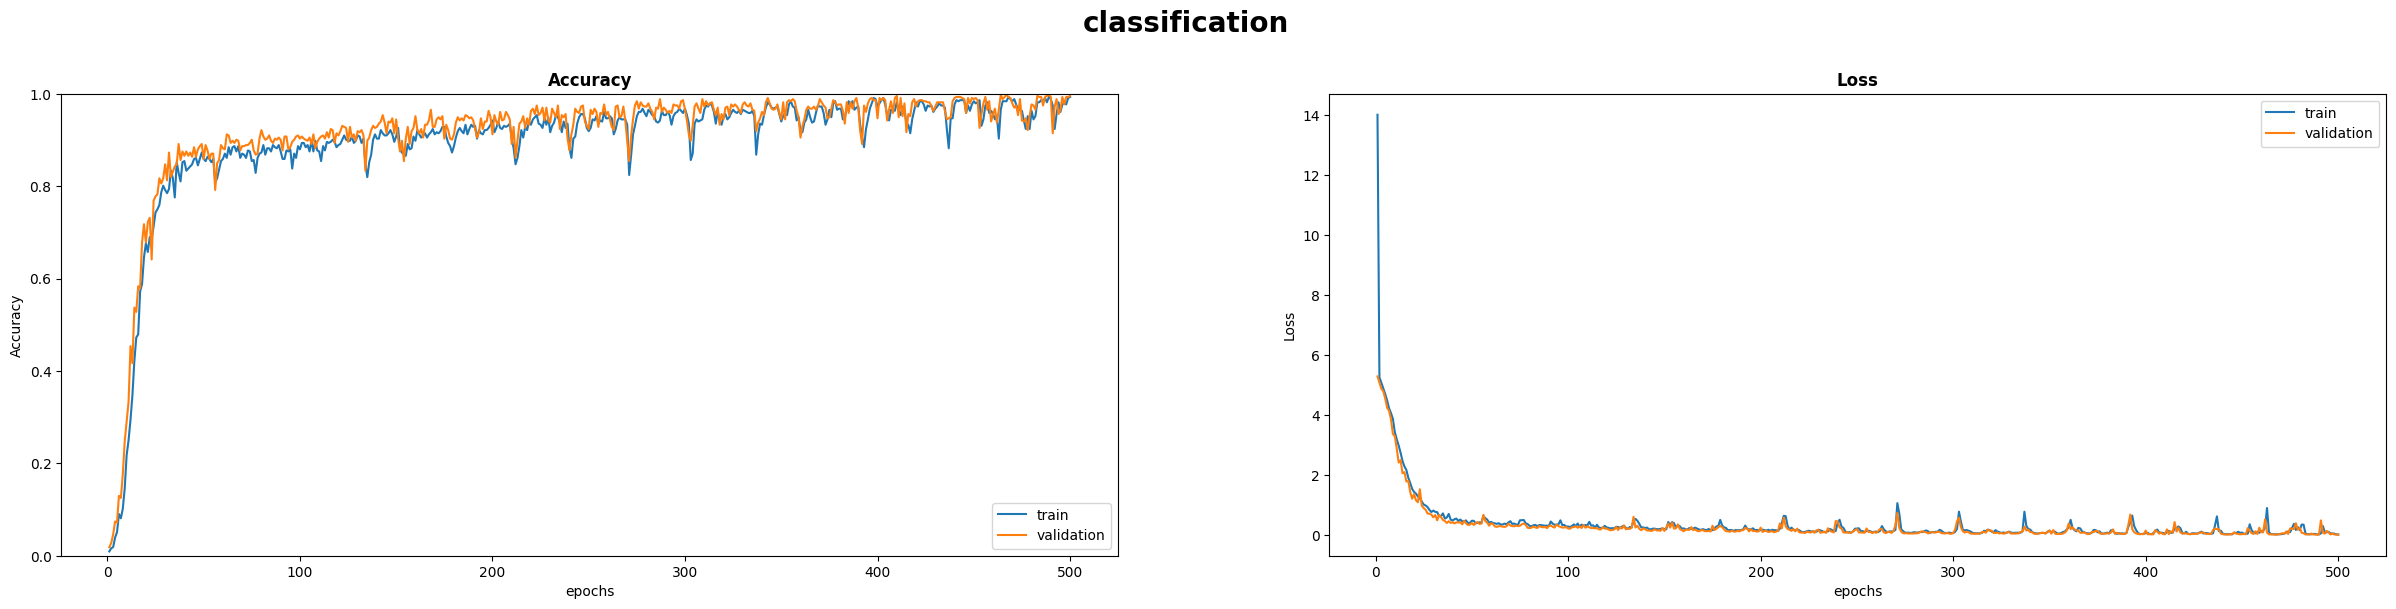

classification: 

╒════════════════════╤══════════════════════════════════╤════════════════════════════════╤═══════════════════════════════════╤═════════════════════════════════╕
│ Number of Layers   │ Accuracy and Loss of train set   │ Accuracy and Loss of val set   │ Accuracy and Loss of train set    │ Accuracy and Loss of val set    │
│                    │ according to Min train Loss      │ according to Min val Loss      │ according to Max train Accuracy   │ according to Max val Accuracy   │
╞════════════════════╪══════════════════════════════════╪════════════════════════════════╪═══════════════════════════════════╪═════════════════════════════════╡
│ classification     │ (epoch index:499)                │ (epoch index:499)              │ (epoch index:467)                 │ (epoch index:463)               │
│                    │ Accuracy: 0.9930555820465088     │ Accuracy: 0.9953703880310059   │ Accuracy: 0.9930555820465088      │ Accuracy: 0.9976851940155029    │
│               

In [236]:
classification_history = print_full_results("classification", classification_model, classification_history_, X_f, Y)

Classify the input note

In [237]:
def NID(note):
    # extracing features 
    note_f = extract_features(note, features_samples=features_samples)
    # finding the output of given note
    out = classification_model(np.array([note_f]))
    # find arg max
    prediction = tf.math.argmax(out[0])
    return labels[prediction.numpy()]

### Test note classification


Note name: G_maj_5

Classified note name: G_maj_5




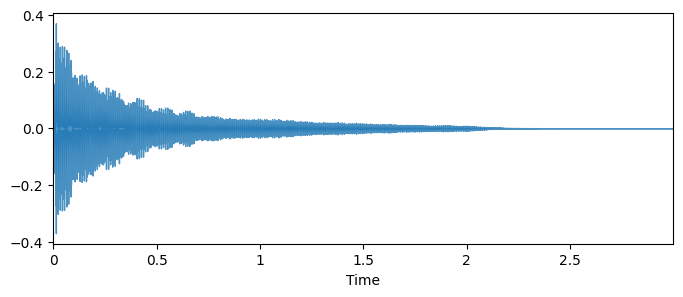

In [238]:
note_id = 378

print("\nNote name:", labels[Y[note_id]])
audio_tmp = NID(X[note_id])
print("\nClassified note name:", audio_tmp)

# playing audio
audio_path = f'/content/dataset/piano_triads/{audio_tmp}_0.wav'
audio, _ = librosa.load(audio_path, sr=sample_rate)
plt.figure(figsize=(8, 3))
librosa.display.waveplot(audio, sample_rate, alpha=0.8)
print("\n")
IPython.display.Audio(audio, rate=sample_rate)


## 4. Predicting the next note

In [239]:
def note2vec(sub_notes_classes):
    vec = []
    for note in sub_notes_classes:
        zeros = np.full((len(labels)), 0)
        index_note = np.where(labels == note)[0][0]
        zeros[index_note] = 1
        vec.append(zeros)
    return vec


note2vec([labels[2]])[0]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

S2S

[Some good descriptions](https://github.com/LukeTonin/keras-seq-2-seq-signal-prediction/blob/master/README.md)

[and](https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639)

By using a single RNN cell in our model we are asking it to be capable of both memorising important events of the past and using these events to predict future values. This is the reasoning behind considering the encoder-decoder for time series prediction. Rather than having a single multi-tasking cell, the model will use two specialised cells. One for memorising important events of the past (encoder) and one for converting the important events into a prediction of the future (decoder).

### Preparing data

In [240]:
songs = sorted(os.listdir(path + '/piano_pieces'))

for song in songs:
    with open(path + "/piano_pieces/" + song) as file:
        l = file.readline()
        if len(l.split(' / ')) < 5:
            songs.remove(song)

# list of tokens
tokens = ['<START>', '<PAD>', '<END>'] + labels.tolist()

# read files
pieces = []
for song in songs:
    with open(path + '/piano_pieces/' + song) as file:
        l = file.readline()
        l = l.strip().split(' / ')
        p = list(map(lambda x: x[:-2], l))
        # pieces to vectors
        p = p[:upper_limit]
        if len(p)==30:
            v = note2vec(p)
            pieces.append(v)

In [241]:
X_pieces = np.array(list(map(lambda x: x[:-1],pieces)))
Y_pieces = np.array(list(map(lambda x: x[-1],pieces)))

### Prediction model

In [242]:
def define_prediction_model(epochs=2, activation="relu", lr=0.001):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(upper_limit - 1, len(labels),)))
    model.add(Dense(len(labels)))

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['accuracy']) 
    # summary method
    model.summary()

    # defining early stop
    # patience is the number of epochs if there is no improvement, the algorithm will early stop.
    # stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # save model to check point
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='accuracy',
        mode='max',
        save_best_only=True)

    # training the model
    # history = model.fit(X_pieces, Y_pieces, epochs=epochs, verbose=0, batch_size=3, validation_split=0.2, callbacks=[TqdmCallback(verbose=0), model_checkpoint_callback])
    # return history, model

In [243]:
define_prediction_model(epochs = 40)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                53400     
                                                                 
 dense (Dense)               (None, 216)               11016     
                                                                 
Total params: 64,416
Trainable params: 64,416
Non-trainable params: 0
_________________________________________________________________


In [244]:
# prediction_history_, prediction_model = define_prediction_model(epochs = 40)

In [245]:
# prediction_model.load_weights(checkpoint_filepath)

In [246]:
# prediction_model.save('prediction_model.hdf5')
# np.save('prediction_history.npy',prediction_history_.history)

In [247]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/prediction_model.hdf5 /content/drive/MyDrive/DL14002_E5/models/
# !cp /content/prediction_history.npy /content/drive/MyDrive/DL14002_E5/models/

In [248]:
!gdown 1GM9D2uttvry5BOE5Tel8dZ4za8_rNdF6
!gdown 1z2BVg8iYYysi0Lx-Skm1_hTINBtf73HX
prediction_model = load_model('prediction_model.hdf5')
prediction_history_=np.load('prediction_history.npy',allow_pickle='TRUE').item()

Downloading...
From: https://drive.google.com/uc?id=1GM9D2uttvry5BOE5Tel8dZ4za8_rNdF6
To: /content/prediction_history.npy
100% 1.80k/1.80k [00:00<00:00, 1.43MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z2BVg8iYYysi0Lx-Skm1_hTINBtf73HX
To: /content/prediction_model.hdf5
100% 803k/803k [00:00<00:00, 78.9MB/s]



Evaluation:
11/11 [==============================] - 0s 9ms/step - loss: 0.0037 - accuracy: 0.7593


Plots:




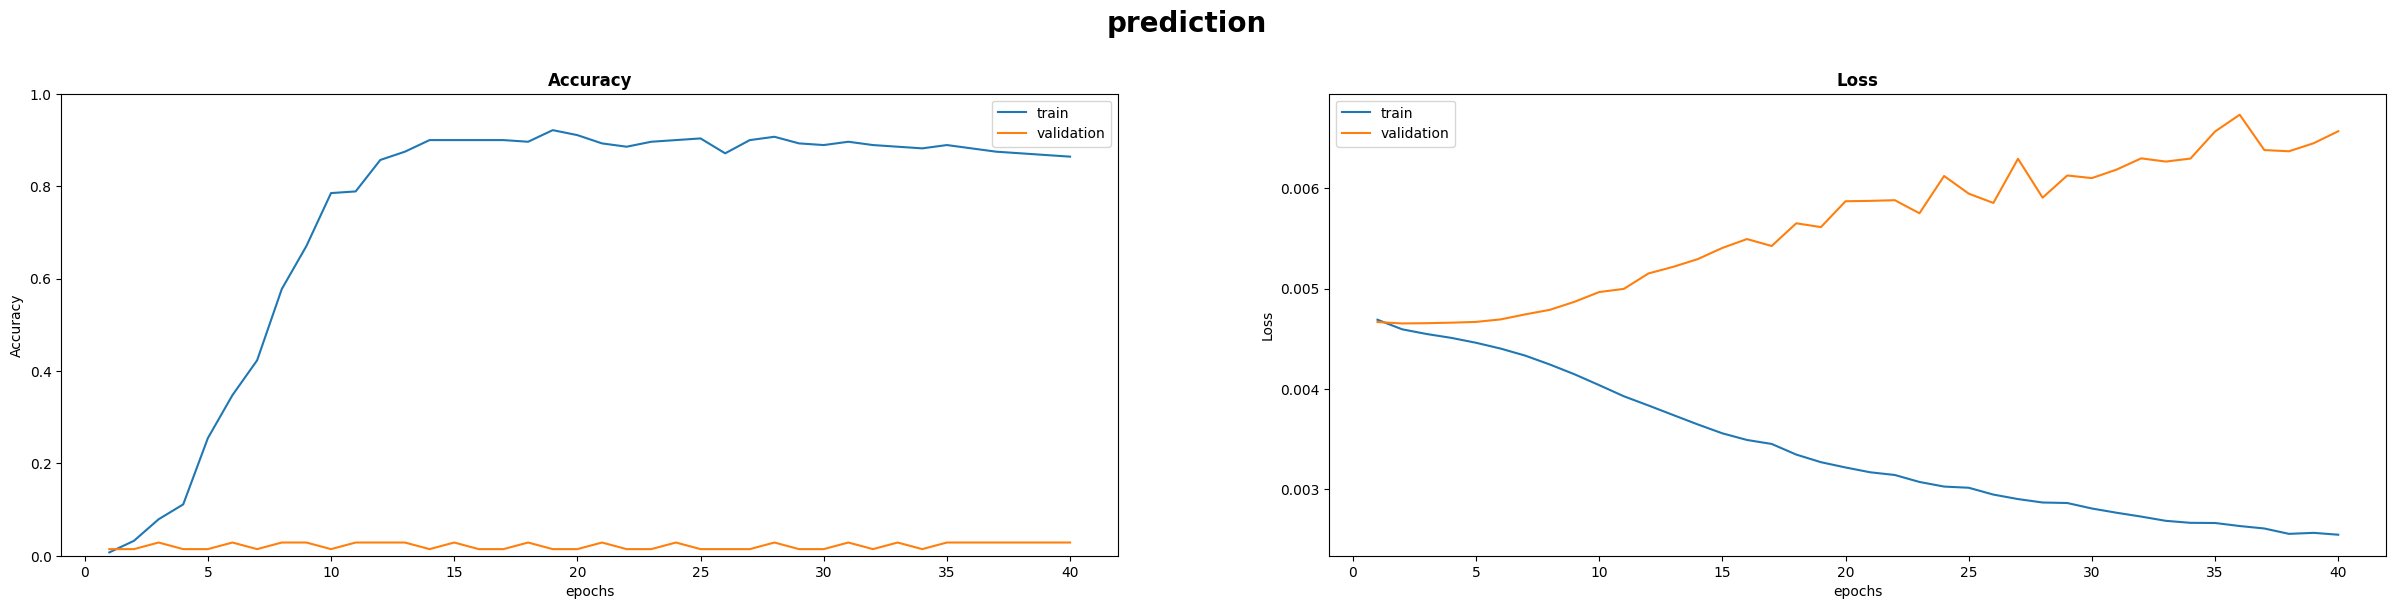

prediction: 

╒════════════════════╤══════════════════════════════════╤════════════════════════════════╤═══════════════════════════════════╤═════════════════════════════════╕
│ Number of Layers   │ Accuracy and Loss of train set   │ Accuracy and Loss of val set   │ Accuracy and Loss of train set    │ Accuracy and Loss of val set    │
│                    │ according to Min train Loss      │ according to Min val Loss      │ according to Max train Accuracy   │ according to Max val Accuracy   │
╞════════════════════╪══════════════════════════════════╪════════════════════════════════╪═══════════════════════════════════╪═════════════════════════════════╡
│ prediction         │ (epoch index:39)                 │ (epoch index:1)                │ (epoch index:18)                  │ (epoch index:2)                 │
│                    │ Accuracy: 0.8637992739677429     │ Accuracy: 0.014285714365541935 │ Accuracy: 0.9211469292640686      │ Accuracy: 0.02857142873108387   │
│                   

In [249]:
prediction_history = print_full_results("prediction", prediction_model, prediction_history_, X_pieces, Y_pieces)

In [250]:
def S2S(sub_notes_vec):
    padding=(upper_limit-len(sub_notes_vec)-1)
    zero = np.array(([[0]*216]*padding))
    sub_notes_vec = np.array(sub_notes_vec)
    padded = np.concatenate((zero, sub_notes_vec), axis=0)

    out = prediction_model(np.array([padded]))
    prediction = tf.math.argmax(out[0])
    return labels[prediction.numpy()]

# ***Algorithm***

In [261]:
notes_list = select_random_notes(n=3)
print("Initial Piece:", notes_list)

initial_piece = append_notes(notes_list, save=True)
noisy_piece = add_random_noise(initial_piece, noise_scale=0.6, save=True)
noisy_piece = initial_piece 

final_piece = None
piece_limit, counter = 25, 0

while True:
    print(f"\nLoop: {counter}")
    denoised_piece = noisy_piece  # DAE(noisy_piece)

    sub_notes = break_down_pieace(denoised_piece)
    sub_notes_classes = [NID(note) for note in sub_notes]
    print("sub_notes_classes:", sub_notes_classes)
    sub_notes_vec = note2vec(sub_notes_classes)

    next_note = S2S(sub_notes_vec)
    print("next_note:", next_note)
    notes_list = sub_notes_classes + [next_note]
    new_piece = append_notes(notes_list)

    if next_note == '<END>' or counter == piece_limit:
        final_piece = new_piece
        break

    else:
        noisy_piece = add_random_noise(new_piece)
        counter += 1
sf.write('final_piece.wav', final_piece, sample_rate)
print("\n\nfinal_piece:", notes_list)

Initial Piece: ['G_dim_6', 'Fs_maj_7', 'Cs_maj_2']

Loop: 0
sub_notes_classes: ['G_dim_6', 'Fs_maj_7', 'Cs_maj_2']
next_note: D_maj_3

Loop: 1
sub_notes_classes: ['Cs_dim_2', 'Cs_maj_5', 'Cs_maj_2', 'D_maj_3']
next_note: C_maj_6

Loop: 2
sub_notes_classes: ['Eb_min_2', 'Eb_min_2', 'D_min_2', 'Eb_min_2', 'Eb_min_2']
next_note: A_maj_6

Loop: 3
sub_notes_classes: ['Eb_min_2', 'Eb_min_2', 'D_min_2', 'Eb_min_2', 'Eb_min_2', 'E_min_6']
next_note: A_maj_6

Loop: 4
sub_notes_classes: ['Eb_min_2', 'Eb_min_2', 'D_min_2', 'Eb_min_2', 'Eb_min_2', 'E_min_6', 'E_dim_2']
next_note: C_maj_6

Loop: 5
sub_notes_classes: ['Eb_min_2', 'Eb_min_2', 'D_min_2', 'Eb_min_2', 'Eb_min_2', 'E_min_6', 'Eb_min_2', 'C_maj_5']
next_note: A_maj_6

Loop: 6
sub_notes_classes: ['Eb_min_2', 'Eb_min_2', 'D_min_2', 'Eb_min_2', 'Eb_min_2', 'E_min_6', 'Eb_min_2', 'E_min_6', 'E_min_6']
next_note: C_maj_6

Loop: 7
sub_notes_classes: ['Eb_min_2', 'Eb_min_2', 'D_min_2', 'Eb_min_2', 'Eb_min_2', 'E_min_6', 'Eb_min_2', 'E_min_6', 'E

In [252]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/final_piece.wav /content/drive/MyDrive/DL14002_E5/music/

# ***Play Audio***

In [262]:
speed = 2

Final Piece

In [254]:
!gdown 1-oElotpRM259pcX5heQ9j4Vjfxoh4JXx
# final_piece: ['Fs_dim_2', 'Eb_min_2', 'Eb_min_2', 'Eb_min_2', 'Eb_min_2', 'D_maj_3', 'Fs_dim_2', 'Eb_min_2', 'C_maj_6']

Downloading...
From: https://drive.google.com/uc?id=1-oElotpRM259pcX5heQ9j4Vjfxoh4JXx
To: /content/final_piece.wav
100% 216k/216k [00:00<00:00, 100MB/s]


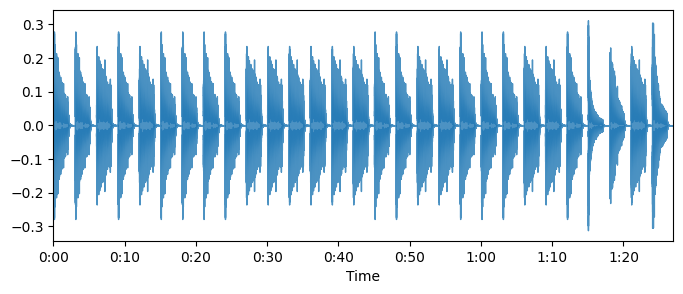

In [263]:
speed = 2

audio_path = '/content/final_piece.wav'
audio, _ = librosa.load(audio_path, sr=sample_rate)
plt.figure(figsize=(8, 3))
librosa.display.waveplot(audio, sample_rate, alpha=0.8)
print("\n")
IPython.display.Audio(audio, rate=sample_rate * speed)

Initial Piece

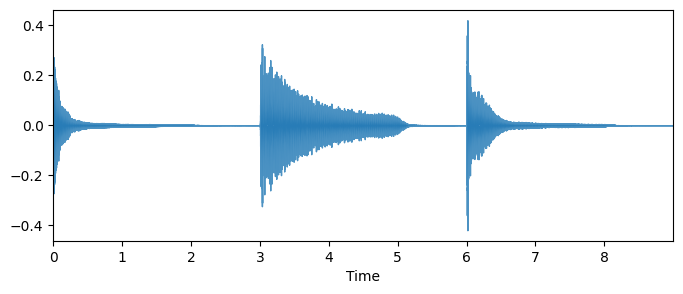

In [256]:
# speed = 3

audio_path = '/content/initial_piece.wav'
audio, _ = librosa.load(audio_path, sr=sample_rate)
plt.figure(figsize=(8, 3))
librosa.display.waveplot(audio, sample_rate, alpha=0.8)
print("\n")
IPython.display.Audio(audio, rate=sample_rate * speed)

sample noise

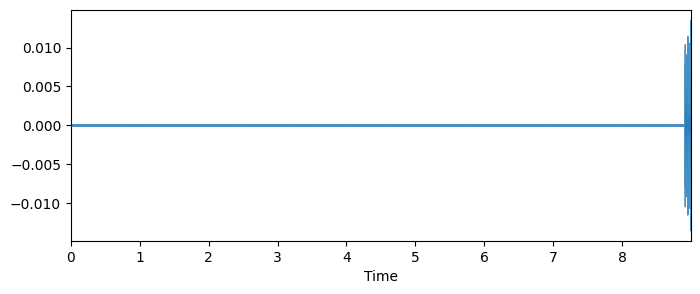

In [257]:
# speed = 3

audio_path = '/content/sample_noise.wav'
audio, _ = librosa.load(audio_path, sr=sample_rate)
plt.figure(figsize=(8, 3))
librosa.display.waveplot(audio, sample_rate, alpha=0.8)
print("\n")
IPython.display.Audio(audio, rate=sample_rate * speed)

piece with noise

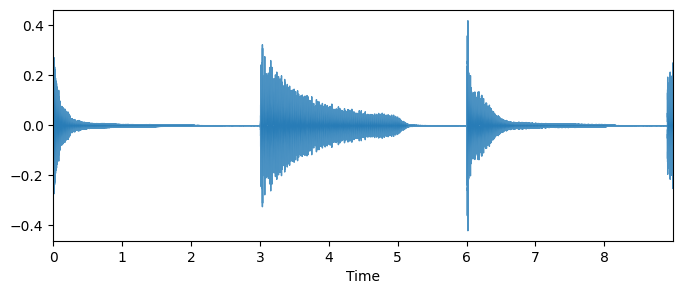

In [258]:
# speed = 3

audio_path = '/content/piece_with_noise.wav'
audio, _ = librosa.load(audio_path, sr=sample_rate)
plt.figure(figsize=(8, 3))
librosa.display.waveplot(audio, sample_rate, alpha=0.8)
print("\n")
IPython.display.Audio(audio, rate=sample_rate * speed)